In [1]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 35.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python -m spacy download xx_ent_wiki_sm  ## bangla tokenizer

2023-03-05 13:32:46.304707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 13:32:47.156359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-05 13:32:47.156466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-05 13:32:47.156486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [4]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
     

cuda


In [5]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
torch.__version__

'1.13.1+cu116'

In [7]:
torchtext.__version__

'0.14.1'

# 1. ETL: Loading the Dataset

In [6]:
# uncomment this if you are not using our department puffer
# import os
# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# path = "/content/ben.txt"

path = open("/content/drive/MyDrive/Colab Notebooks/NLP/data/eng-ban.txt", encoding='UTF-8').read().strip().split('\n')  

def load_data(path):
  #ext = path.read_text(encoding='utf-8')
  with open(path, "r", encoding="utf8") as file:
    text = file.read()

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context, _ in pairs])
  target = np.array([target for target, context, _ in pairs])

  return target, context

In [7]:
word_pairs = [[w for w in l.split('\t')] for l in path]
word_pairs[20]

['Attack!',
 'আক্রমণ!',
 'CC-BY 2.0 (France) Attribution: tatoeba.org #1972610 (CK) & #5489253 (tanay)']

In [8]:
data = pd.DataFrame(word_pairs, columns=["en", "bn", "extra"])

In [9]:
# dropping the third column 
data = data.drop("extra", axis=1)

In [11]:
data[50:55]

,en,bn
50,Call me.,আমাকে ডাকিস।
51,Call us.,আমাদের ডেকো।
52,Call us.,আমাদের ডাকিস।
53,Call us.,আমাদের ডাকবেন।
54,Come in.,ভেতরে আসুন।


In [12]:
columns_titles = ["bn","en"]
data = data.reindex(columns=columns_titles)

In [13]:
data.head(5)

,bn,en
0,যাও।,Go.
1,যান।,Go.
2,যা।,Go.
3,পালাও!,Run!
4,পালান!,Run!


In [14]:
dataset = data.values.tolist()

# 2. EDA

In [15]:
dataset_size = len(dataset)
dataset_size

5514

In [16]:
#split

random.shuffle(dataset)
train_data_set_size = int(dataset_size *0.8)

train_dataset = dataset[:train_data_set_size]
test = dataset[train_data_set_size:]

train_size = int(train_data_set_size *0.8)
train = train_dataset[:train_size]
val = train_dataset[train_size:]

In [17]:
assert sum((len(train),len(val),len(test))) == dataset_size

# 3. Preprocessing

## Tokenizing

In [18]:
# place-holders
token_transform = {}
vocab_transform = {}

In [19]:
from torchtext.data.utils import get_tokenizer

SRC_LANGUAGE = 'bn'
TRG_LANGUAGE = 'en'

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='xx_ent_wiki_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [21]:
# tokenization for bangla
print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](train[0][0]))

Sentence:  আমি আপনাকে অবাক করার চেষ্টা ছেড়ে দিয়েছি।
Tokenization:  ['আমি', 'আপনাকে', 'অবাক', 'করার', 'চেষ্টা', 'ছেড়ে', 'দিয়েছি', '।']


In [22]:
# tokenization for english
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train[0][1]))

Sentence:  I've given up on trying to surprise you.
Tokenization:  ['I', "'ve", 'given', 'up', 'on', 'trying', 'to', 'surprise', 'you', '.']


In [23]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) # either first or second index

In [24]:
# defining special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# making sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Text to Integers (Numericalization)

In [25]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # creating torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   # if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) # indicates whether to insert symbols at the beginning or at the end                                            
# Setting UNK_IDX as the default index. This index is returned when the token is not found. 
# If not, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [26]:
import pickle
with open('vocab_transform.pickle', 'wb') as f:
    pickle.dump(vocab_transform, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# checking some examples
vocab_transform[TRG_LANGUAGE](['I', 'love', 'programming'])

[5, 242, 0]

In [29]:
# we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

# printing 100, for example
mapping[100]

'নাম'

In [30]:
# let's try unknown vocab
mapping[0]
# they will all map to <unk> which has 0 as integer

'<unk>'

In [31]:
# let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [32]:
# checking unique vocabularies
len(mapping)

1391

# 4. Preparing the DataLoader

In [33]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [34]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [35]:
for bn, _, en in train_loader:
    break

In [36]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Bengali shape: ", bn.shape)   # (seq len, batch_size)

English shape:  torch.Size([11, 64])
Bengali shape:  torch.Size([11, 64])


# 5. Designing the Model

## Encoder

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        # src = [src len, batch size]
        # src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        # embedded = [src len, batch size, emb dim]
                
        # need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        
        # packed_outputs is a packed sequence containing all hidden states
        # hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        # outputs is now a non-packed sequence, all hidden states obtained
        # when the input is a pad token are all zeros
            
        # outputs = [src len, batch size, hid dim * num directions]
        # hidden = [n layers * num directions, batch size, hid dim]
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        # outputs = [src len, batch size, hid dim * 2]
        # hidden = [batch size, hid dim]
        
        return outputs, hidden

## Attention

In [103]:
# class Attention(nn.Module):
#     def __init__(self, hid_dim, variants):
#         super().__init__()
        
#         self.v = nn.Linear(hid_dim, 1, bias = False)
#         self.W = nn.Linear(hid_dim,     hid_dim) # for decoder
#         self.U = nn.Linear(hid_dim * 2, hid_dim) # for encoder outputs
                
#     def forward(self, hidden, encoder_outputs, mask):
        
#         # hidden = [batch size, hid dim]
#         # encoder_outputs = [src len, batch size, hid dim * 2]
        
#         batch_size = encoder_outputs.shape[1]
#         src_len = encoder_outputs.shape[0]
        
#         # repeat decoder hidden state src_len times
#         hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
#         # hidden = [batch size, src len, hid dim]

#         encoder_outputs = encoder_outputs.permute(1, 0, 2)
#         # encoder_outputs = [batch size, src len, hid dim * 2]
        
#         energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
#         # energy = [batch size, src len, hid dim]
        
#         attention = self.v(energy).squeeze(2)
#         # attention = [batch size, src len]
        
#         # use masked_fill_ if you want in-place
#         attention = attention.masked_fill(mask, -1e10)
        
#         return F.softmax(attention, dim = 1)

In [104]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]
            
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            #energy = [batch size, src len, hid dim]
            
            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]

            #use masked_fill_ if you want in-place
            attention = attention.masked_fill(mask, -1e10)
            
        elif self.variants == 'general': #work
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            #attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)
            #wh = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)

        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

In [105]:
# example of masked_fill
# reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


## Decoder

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
                
    def forward(self, input, hidden, encoder_outputs, mask):
             
        # input = [batch size]
        # hidden = [batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim * 2]
        # mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        # input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        # a = [batch size, src len]
        
        a = a.unsqueeze(1)
        # a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (hid dim * 2) + emb dim]
            
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        # output = [seq len, batch size, dec hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [1, batch size, hid dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
               
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        # prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

## Putting them together (become Seq2Seq!)

In [106]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src == self.src_pad_idx).permute(1, 0)  # permute so it's the same shape as attention
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src len, batch size]
        # src_len = [batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
                
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # tensor to store attentiont outputs from decoder
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        # first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        mask = self.create_mask(src)
        # mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            # insert input token embedding, previous hidden state, all encoder hidden states and mask
            # receive output tensor (predictions) and new hidden state
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            # output    = [batch size, output dim]
            # hidden    = [batch size, hid dim]
            # attention = [batch size, src len]
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # place attentions in a tensor holding attention for each token
            attentions[t] = attention
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

# 6. Training

In [107]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

## 6.1 General Attention

In [108]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants = 'general')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(1391, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(1130, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=1130, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [109]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

356096
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
289280
1966080
786432
  1536
  1536
2024960
  1130
______
9105258


In [110]:
import torch.optim as optim

lr = 0.001

# training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) # combining softmax with cross entropy

In [111]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        # trg    = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        # the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        # trg    = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # clipping the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [112]:
def evaluate(model, loader, criterion, loader_length):
        
    # turning off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            # trg    = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg    = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [113]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [114]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [115]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    # lower perplexity is better

Epoch: 01 | Time: 0m 4s
	Train Loss: 5.006 | Train PPL: 149.289
	 Val. Loss: 4.224 |  Val. PPL:  68.335
Epoch: 02 | Time: 0m 2s
	Train Loss: 4.099 | Train PPL:  60.299
	 Val. Loss: 3.944 |  Val. PPL:  51.648
Epoch: 03 | Time: 0m 2s
	Train Loss: 3.718 | Train PPL:  41.202
	 Val. Loss: 3.778 |  Val. PPL:  43.711
Epoch: 04 | Time: 0m 3s
	Train Loss: 3.420 | Train PPL:  30.573
	 Val. Loss: 3.660 |  Val. PPL:  38.863
Epoch: 05 | Time: 0m 3s
	Train Loss: 3.196 | Train PPL:  24.440
	 Val. Loss: 3.469 |  Val. PPL:  32.105
Epoch: 06 | Time: 0m 2s
	Train Loss: 2.937 | Train PPL:  18.864
	 Val. Loss: 3.378 |  Val. PPL:  29.309
Epoch: 07 | Time: 0m 2s
	Train Loss: 2.735 | Train PPL:  15.415
	 Val. Loss: 3.309 |  Val. PPL:  27.369
Epoch: 08 | Time: 0m 3s
	Train Loss: 2.543 | Train PPL:  12.719
	 Val. Loss: 3.271 |  Val. PPL:  26.337
Epoch: 09 | Time: 0m 3s
	Train Loss: 2.375 | Train PPL:  10.751
	 Val. Loss: 3.140 |  Val. PPL:  23.093
Epoch: 10 | Time: 0m 2s
	Train Loss: 2.216 | Train PPL:   9.175


Text(0, 0.5, 'loss')

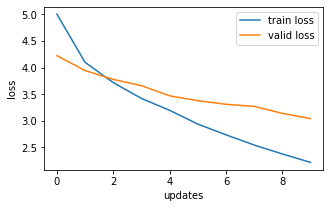

In [116]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [117]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.046 | Test PPL:  21.025 |


In [118]:
# model

## 6.2 Multiplicative Attention

In [119]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants = 'multiplicative')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

mul_model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
mul_model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(1391, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(1130, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=1130, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [120]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in mul_model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(mul_model)

356096
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
289280
1966080
786432
  1536
  1536
2024960
  1130
______
9105258


In [121]:
import torch.optim as optim

lr = 0.001

# training hyperparameters
optimizer = optim.Adam(mul_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) # combining softmax with cross entropy

In [122]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        # trg    = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        # the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        # trg    = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # clipping the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [123]:
def evaluate(model, loader, criterion, loader_length):
        
    # turning off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            # trg    = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg    = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [124]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [125]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [126]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'{mul_model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(mul_model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(mul_model, valid_loader, criterion, val_loader_length)
    
    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(mul_model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    # lower perplexity is better

Epoch: 01 | Time: 0m 3s
	Train Loss: 5.075 | Train PPL: 159.973
	 Val. Loss: 4.234 |  Val. PPL:  68.959
Epoch: 02 | Time: 0m 3s
	Train Loss: 4.132 | Train PPL:  62.281
	 Val. Loss: 4.058 |  Val. PPL:  57.865
Epoch: 03 | Time: 0m 3s
	Train Loss: 3.837 | Train PPL:  46.376
	 Val. Loss: 3.993 |  Val. PPL:  54.198
Epoch: 04 | Time: 0m 3s
	Train Loss: 3.547 | Train PPL:  34.719
	 Val. Loss: 3.672 |  Val. PPL:  39.338
Epoch: 05 | Time: 0m 3s
	Train Loss: 3.304 | Train PPL:  27.228
	 Val. Loss: 3.693 |  Val. PPL:  40.170
Epoch: 06 | Time: 0m 3s
	Train Loss: 3.113 | Train PPL:  22.479
	 Val. Loss: 3.480 |  Val. PPL:  32.450
Epoch: 07 | Time: 0m 3s
	Train Loss: 2.909 | Train PPL:  18.344
	 Val. Loss: 3.529 |  Val. PPL:  34.074
Epoch: 08 | Time: 0m 3s
	Train Loss: 2.759 | Train PPL:  15.783
	 Val. Loss: 3.290 |  Val. PPL:  26.832
Epoch: 09 | Time: 0m 3s
	Train Loss: 2.546 | Train PPL:  12.751
	 Val. Loss: 3.238 |  Val. PPL:  25.485
Epoch: 10 | Time: 0m 3s
	Train Loss: 2.362 | Train PPL:  10.615


Text(0, 0.5, 'loss')

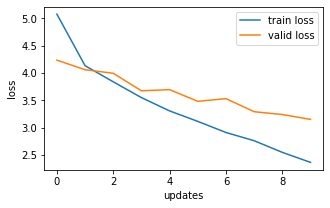

In [127]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [128]:
mul_model.load_state_dict(torch.load(save_path))
test_loss = evaluate(mul_model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.118 | Test PPL:  22.609 |


## 6.3 Additive Attention

In [129]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants = 'additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

add_model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
add_model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(1391, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(1130, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=1130, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [130]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in add_model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(add_model)

356096
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
289280
1966080
786432
  1536
  1536
2024960
  1130
______
9105258


In [131]:
import torch.optim as optim

lr = 0.001

# training hyperparameters
optimizer = optim.Adam(add_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) # combining softmax with cross entropy

In [132]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        # trg    = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        # the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        # trg    = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # clipping the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [133]:
def evaluate(model, loader, criterion, loader_length):
        
    # turning off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            # trg    = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg    = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [134]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [135]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [136]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'{add_model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(add_model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(add_model, valid_loader, criterion, val_loader_length)
    
    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(add_model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    # lower perplexity is better

Epoch: 01 | Time: 0m 4s
	Train Loss: 4.966 | Train PPL: 143.517
	 Val. Loss: 4.222 |  Val. PPL:  68.152
Epoch: 02 | Time: 0m 4s
	Train Loss: 4.053 | Train PPL:  57.578
	 Val. Loss: 3.894 |  Val. PPL:  49.083
Epoch: 03 | Time: 0m 4s
	Train Loss: 3.656 | Train PPL:  38.702
	 Val. Loss: 3.664 |  Val. PPL:  38.999
Epoch: 04 | Time: 0m 4s
	Train Loss: 3.414 | Train PPL:  30.383
	 Val. Loss: 3.581 |  Val. PPL:  35.915
Epoch: 05 | Time: 0m 4s
	Train Loss: 3.139 | Train PPL:  23.082
	 Val. Loss: 3.417 |  Val. PPL:  30.472
Epoch: 06 | Time: 0m 4s
	Train Loss: 2.855 | Train PPL:  17.369
	 Val. Loss: 3.362 |  Val. PPL:  28.850
Epoch: 07 | Time: 0m 4s
	Train Loss: 2.652 | Train PPL:  14.185
	 Val. Loss: 3.262 |  Val. PPL:  26.094
Epoch: 08 | Time: 0m 4s
	Train Loss: 2.427 | Train PPL:  11.330
	 Val. Loss: 3.099 |  Val. PPL:  22.165
Epoch: 09 | Time: 0m 4s
	Train Loss: 2.192 | Train PPL:   8.954
	 Val. Loss: 3.077 |  Val. PPL:  21.688
Epoch: 10 | Time: 0m 4s
	Train Loss: 2.023 | Train PPL:   7.558


Text(0, 0.5, 'loss')

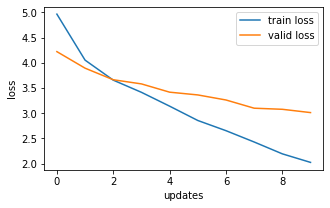

In [137]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [138]:
add_model.load_state_dict(torch.load(save_path))
test_loss = evaluate(add_model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.974 | Test PPL:  19.569 |


In [ ]:
add_model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(1139, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(947, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=947, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

# 7. Testing on Some Random News

In [139]:
test[0][0]

'ও এখন লাঞ্চ করছে।'

In [140]:
test[0][1]

'She is having lunch now.'

In [141]:
src_text = text_transform[SRC_LANGUAGE](test[0][0]).to(device)
src_text

tensor([  2,  53,  47, 300,  65,   4,   3], device='cuda:0')

In [142]:
trg_text = text_transform[TRG_LANGUAGE](test[0][1]).to(device)
trg_text

tensor([  2,  46,  11, 420, 213,  70,   4,   3], device='cuda:0')

In [143]:
src_text = src_text.reshape(-1, 1)  # because batch_size is 1

In [144]:
trg_text = trg_text.reshape(-1, 1)

In [145]:
src_text.shape, trg_text.shape

(torch.Size([7, 1]), torch.Size([8, 1]))

In [146]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [147]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) # turn off teacher forcing

In [148]:
output.shape # trg_len, batch_size, trg_output_dim

torch.Size([8, 1, 1130])

In [149]:
output = output.squeeze(1)

In [150]:
output.shape

torch.Size([8, 1130])

In [151]:
output = output[1:]
output.shape # trg_len, trg_output_dim

torch.Size([7, 1130])

In [152]:
output_max = output.argmax(1) # returns max indices

In [153]:
output_max

tensor([ 23,  14,  27, 239,  70,   4,   3], device='cuda:0')

In [154]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [155]:
for token in output_max:
    print(mapping[token.item()])

He
's
your
daughter
now
.
<eos>


# 8. Attention

In [156]:
attentions.shape

torch.Size([8, 1, 7])

In [157]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](test[0][0]) + ['<eos>']
src_tokens

['<sos>', 'ও', 'এখন', 'লাঞ্চ', 'করছে', '।', '<eos>']

In [158]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', 'He', "'s", 'your', 'daughter', 'now', '.', '<eos>']

In [159]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-159-b23710e830bc>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-159-b23710e830bc>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


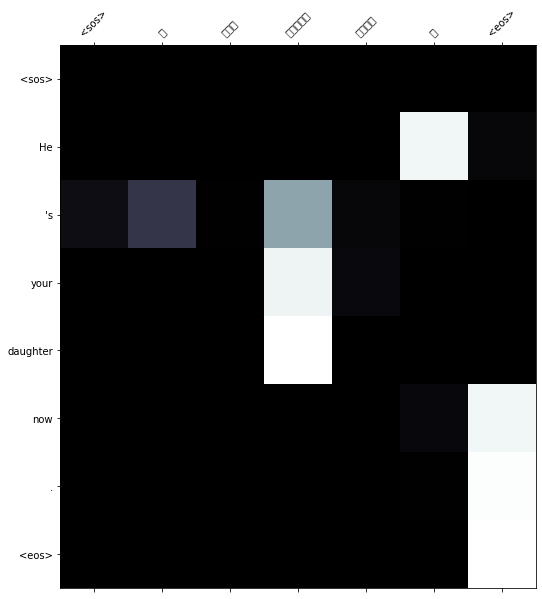

In [160]:
display_attention(src_tokens, trg_tokens, attentions)